In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 11

RANDOM_SEED = 2

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/weather_data.csv")

In [ ]:
df['hour'] = pd.to_datetime(df['MST'],format='%H:%M').dt.hour

In [ ]:
#plt.plot(df['hour'][:10000],df['Global CMP22 (vent/cor) [W/m^2]'][:10000])

In [ ]:
#df = df.loc[(df['hour'] >= 8) & (df['hour'] < 15)].reset_index(drop=True)

In [ ]:
df.shape

(527040, 18)

In [ ]:
#df.head()

In [ ]:
df = df[df['Total Cloud Cover [%]'] >= -1]

In [ ]:
df.rename(columns = {'Direct sNIP [W/m^2]':'snip', 'Total Cloud Cover [%]': 'cloud cover', 
                     'Peak Wind Speed @ 6ft [m/s]': 'wind speed', 
                     'Avg Wind Direction @ 6ft [deg from N]': 'wind dir',
                     'Tower RH [%]': 'rh', 'Global CMP22 (vent/cor) [W/m^2]': 'irr',
                     'Moisture': 'moisture', 'Tower Dry Bulb Temp [deg C]': 'temp', 
                     'Albedo (CMP11)': 'albedo', 
                     }, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df.corr()

,irr,snip,Azimuth Angle [degrees],temp,Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],rh,cloud cover,wind speed,wind dir,Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],moisture,albedo,hour
irr,1.000000,0.846761,-0.033719,0.397891,0.333088,0.147975,-0.293181,0.371537,0.159540,-0.225188,0.029994,-0.033401,0.011182,-0.116255,0.410318,-0.019102
snip,0.846761,1.000000,-0.067825,0.290339,0.213872,0.001558,-0.326873,0.085457,0.126164,-0.142608,0.045951,-0.038740,0.015475,-0.155522,0.447310,-0.046819
Azimuth Angle [degrees],-0.033719,-0.067825,1.000000,0.120762,0.096672,0.033687,-0.090139,0.072468,0.029694,-0.054961,-0.032735,0.151393,0.020222,0.035155,-0.041532,0.957609
temp,0.397891,0.290339,0.120762,1.000000,0.950478,0.586786,-0.612243,0.232985,0.118328,0.027097,0.124106,-0.147556,0.015701,-0.293524,-0.049699,0.111475
Tower Wet Bulb Temp [deg C],0.333088,0.213872,0.096672,0.950478,1.000000,0.796595,-0.383760,0.229820,0.046930,-0.033973,0.156214,-0.093334,0.006927,-0.213877,-0.071611,0.093971
Tower Dew Point Temp [deg C],0.147975,0.001558,0.033687,0.586786,0.796595,1.000000,0.214930,0.206000,-0.126807,-0.191966,0.162079,0.033274,-0.011084,0.042528,-0.060737,0.040569
rh,-0.293181,-0.326873,-0.090139,-0.612243,-0.383760,0.214930,1.000000,-0.020863,-0.280380,-0.286628,-0.007372,0.239518,-0.036448,0.526999,0.040994,-0.078300
cloud cover,0.371537,0.085457,0.072468,0.232985,0.229820,0.206000,-0.020863,1.000000,0.051931,-0.264932,-0.060775,0.025339,-0.008049,0.099375,0.477960,0.055419
wind speed,0.159540,0.126164,0.029694,0.118328,0.046930,-0.126807,-0.280380,0.051931,1.000000,0.314350,-0.126252,-0.033795,0.005799,-0.101675,0.003901,0.016837
wind dir,-0.225188,-0.142608,-0.054961,0.027097,-0.033973,-0.191966,-0.286628,-0.264932,0.314350,1.000000,-0.015057,-0.035118,0.012347,-0.189483,-0.194389,-0.056809


In [ ]:
req_cols = ['snip', 'hour', 'cloud cover', 'albedo', 'rh', 'temp', 'irr']

df = df[req_cols]

df.head()

,snip,hour,cloud cover,albedo,rh,temp,irr
0,0.000000,0,-1,0.0,32.33,7.216,-0.962276
1,0.000000,0,-1,0.0,32.40,7.251,-0.937921
2,0.000000,0,-1,0.0,32.54,7.256,-0.944395
3,-0.029673,0,-1,0.0,31.89,7.254,-0.951350
4,-0.054401,0,-1,0.0,31.78,7.331,-0.934976


In [ ]:
df.corr()

,snip,hour,cloud cover,albedo,rh,temp,irr
snip,1.000000,-0.046819,0.085457,0.447310,-0.326873,0.290339,0.846761
hour,-0.046819,1.000000,0.055419,-0.033953,-0.078300,0.111475,-0.019102
cloud cover,0.085457,0.055419,1.000000,0.477960,-0.020863,0.232985,0.371537
albedo,0.447310,-0.033953,0.477960,1.000000,0.040994,-0.049699,0.410318
rh,-0.326873,-0.078300,-0.020863,0.040994,1.000000,-0.612243,-0.293181
temp,0.290339,0.111475,0.232985,-0.049699,-0.612243,1.000000,0.397891
irr,0.846761,-0.019102,0.371537,0.410318,-0.293181,0.397891,1.000000


In [ ]:
df.shape

(525511, 7)

In [ ]:
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

367857 157654


# Preprocessing

In [ ]:
#df.head()

In [ ]:

from sklearn.preprocessing import RobustScaler

f_columns = req_cols[:-1]

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['irr']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['irr'] = cnt_transformer.transform(train[['irr']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['irr'] = cnt_transformer.transform(test[['irr']])


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [ ]:
df.corr()

,snip,hour,cloud cover,albedo,rh,temp,irr
snip,1.000000,-0.046819,0.085457,0.447310,-0.326873,0.290339,0.846761
hour,-0.046819,1.000000,0.055419,-0.033953,-0.078300,0.111475,-0.019102
cloud cover,0.085457,0.055419,1.000000,0.477960,-0.020863,0.232985,0.371537
albedo,0.447310,-0.033953,0.477960,1.000000,0.040994,-0.049699,0.410318
rh,-0.326873,-0.078300,-0.020863,0.040994,1.000000,-0.612243,-0.293181
temp,0.290339,0.111475,0.232985,-0.049699,-0.612243,1.000000,0.397891
irr,0.846761,-0.019102,0.371537,0.410318,-0.293181,0.397891,1.000000


In [ ]:

def create_dataset(X, y, time_steps, ccmin = 0):
  Xs, ys = [], []
  for i in range(len(X)- data_window - time_steps):
    if (y.to_numpy()[i] == ccmin) or (y.to_numpy()[i + data_window + time_steps] == ccmin):
      continue
    Xs.append(X.iloc[i:(i + data_window)].values)        
    ys.append(y.iloc[i + data_window + time_steps])
  return np.array(Xs), np.array(ys)


In [ ]:
'''
def create_dataset(X, y, time_steps, ccmin = 0):
    Xs, ys = [], []
    for i in range(len(X) - data_window - time_steps):
        Xs.append(X.iloc[i:(i + data_window)].values)        
        ys.append(y.iloc[i + time_steps + data_window])
    return np.array(Xs), np.array(ys)
'''

'\ndef create_dataset(X, y, time_steps, ccmin = 0):\n    Xs, ys = [], []\n    for i in range(len(X) - data_window - time_steps):\n        Xs.append(X.iloc[i:(i + data_window)].values)        \n        ys.append(y.iloc[i + time_steps + data_window])\n    return np.array(Xs), np.array(ys)\n'

In [ ]:
time_steps = 20
data_window = 30

# reshape to [samples, time_steps, n_features]

#X_train, y_train = create_dataset(train, train['irr'], time_steps, train['cloud cover'].min())
#X_test, y_test = create_dataset(test, test['irr'], time_steps, train['cloud cover'].min())

X_train, y_train = create_dataset(train, train['irr'], time_steps)
X_test, y_test = create_dataset(test, test['irr'], time_steps)

print(X_train.shape, y_train.shape)

(367805, 30, 7) (367805,)


In [ ]:

model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=16, 
      input_shape=(X_train.shape[1], X_train.shape[2]),
      return_sequences=False
    )
  )
)
model.add(keras.layers.Dropout(rate=0.1))


opt = keras.optimizers.Adam(learning_rate=0.0001)
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer=opt)
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)


In [ ]:
'''
model = keras.Sequential()
model.add(
    keras.layers.GRU(
      units=16, 
      input_shape=(X_train.shape[1], X_train.shape[2]),
      return_sequences=False
    )
)
model.add(keras.layers.Dropout(rate=0.1))


opt = keras.optimizers.Adam(learning_rate=0.002)
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer=opt)
'''

"\nmodel = keras.Sequential()\nmodel.add(\n    keras.layers.GRU(\n      units=16, \n      input_shape=(X_train.shape[1], X_train.shape[2]),\n      return_sequences=False\n    )\n)\nmodel.add(keras.layers.Dropout(rate=0.1))\n\n\nopt = keras.optimizers.Adam(learning_rate=0.002)\nmodel.add(keras.layers.Dense(units=1))\nmodel.compile(loss='mean_squared_error', optimizer=opt)\n"

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=200, 
    batch_size=600, 
    validation_split=0.2,
    shuffle=False,
    callbacks = callback,
)

Epoch 1/200
491/491 [==============================] - 13s 19ms/step - loss: 0.5357 - val_loss: 0.2558
Epoch 2/200
491/491 [==============================] - 8s 16ms/step - loss: 0.1969 - val_loss: 0.1444
Epoch 3/200
491/491 [==============================] - 8s 17ms/step - loss: 0.1415 - val_loss: 0.1139
Epoch 4/200
491/491 [==============================] - 8s 17ms/step - loss: 0.1172 - val_loss: 0.1051
Epoch 5/200
491/491 [==============================] - 8s 17ms/step - loss: 0.1069 - val_loss: 0.1002
Epoch 6/200
491/491 [==============================] - 8s 17ms/step - loss: 0.1019 - val_loss: 0.0969
Epoch 7/200
491/491 [==============================] - 8s 17ms/step - loss: 0.0976 - val_loss: 0.0943
Epoch 8/200
491/491 [==============================] - 8s 17ms/step - loss: 0.0947 - val_loss: 0.0924
Epoch 9/200
491/491 [==============================] - 8s 17ms/step - loss: 0.0921 - val_loss: 0.0910
Epoch 10/200
491/491 [==============================] - 8s 17ms/step - loss: 0.09

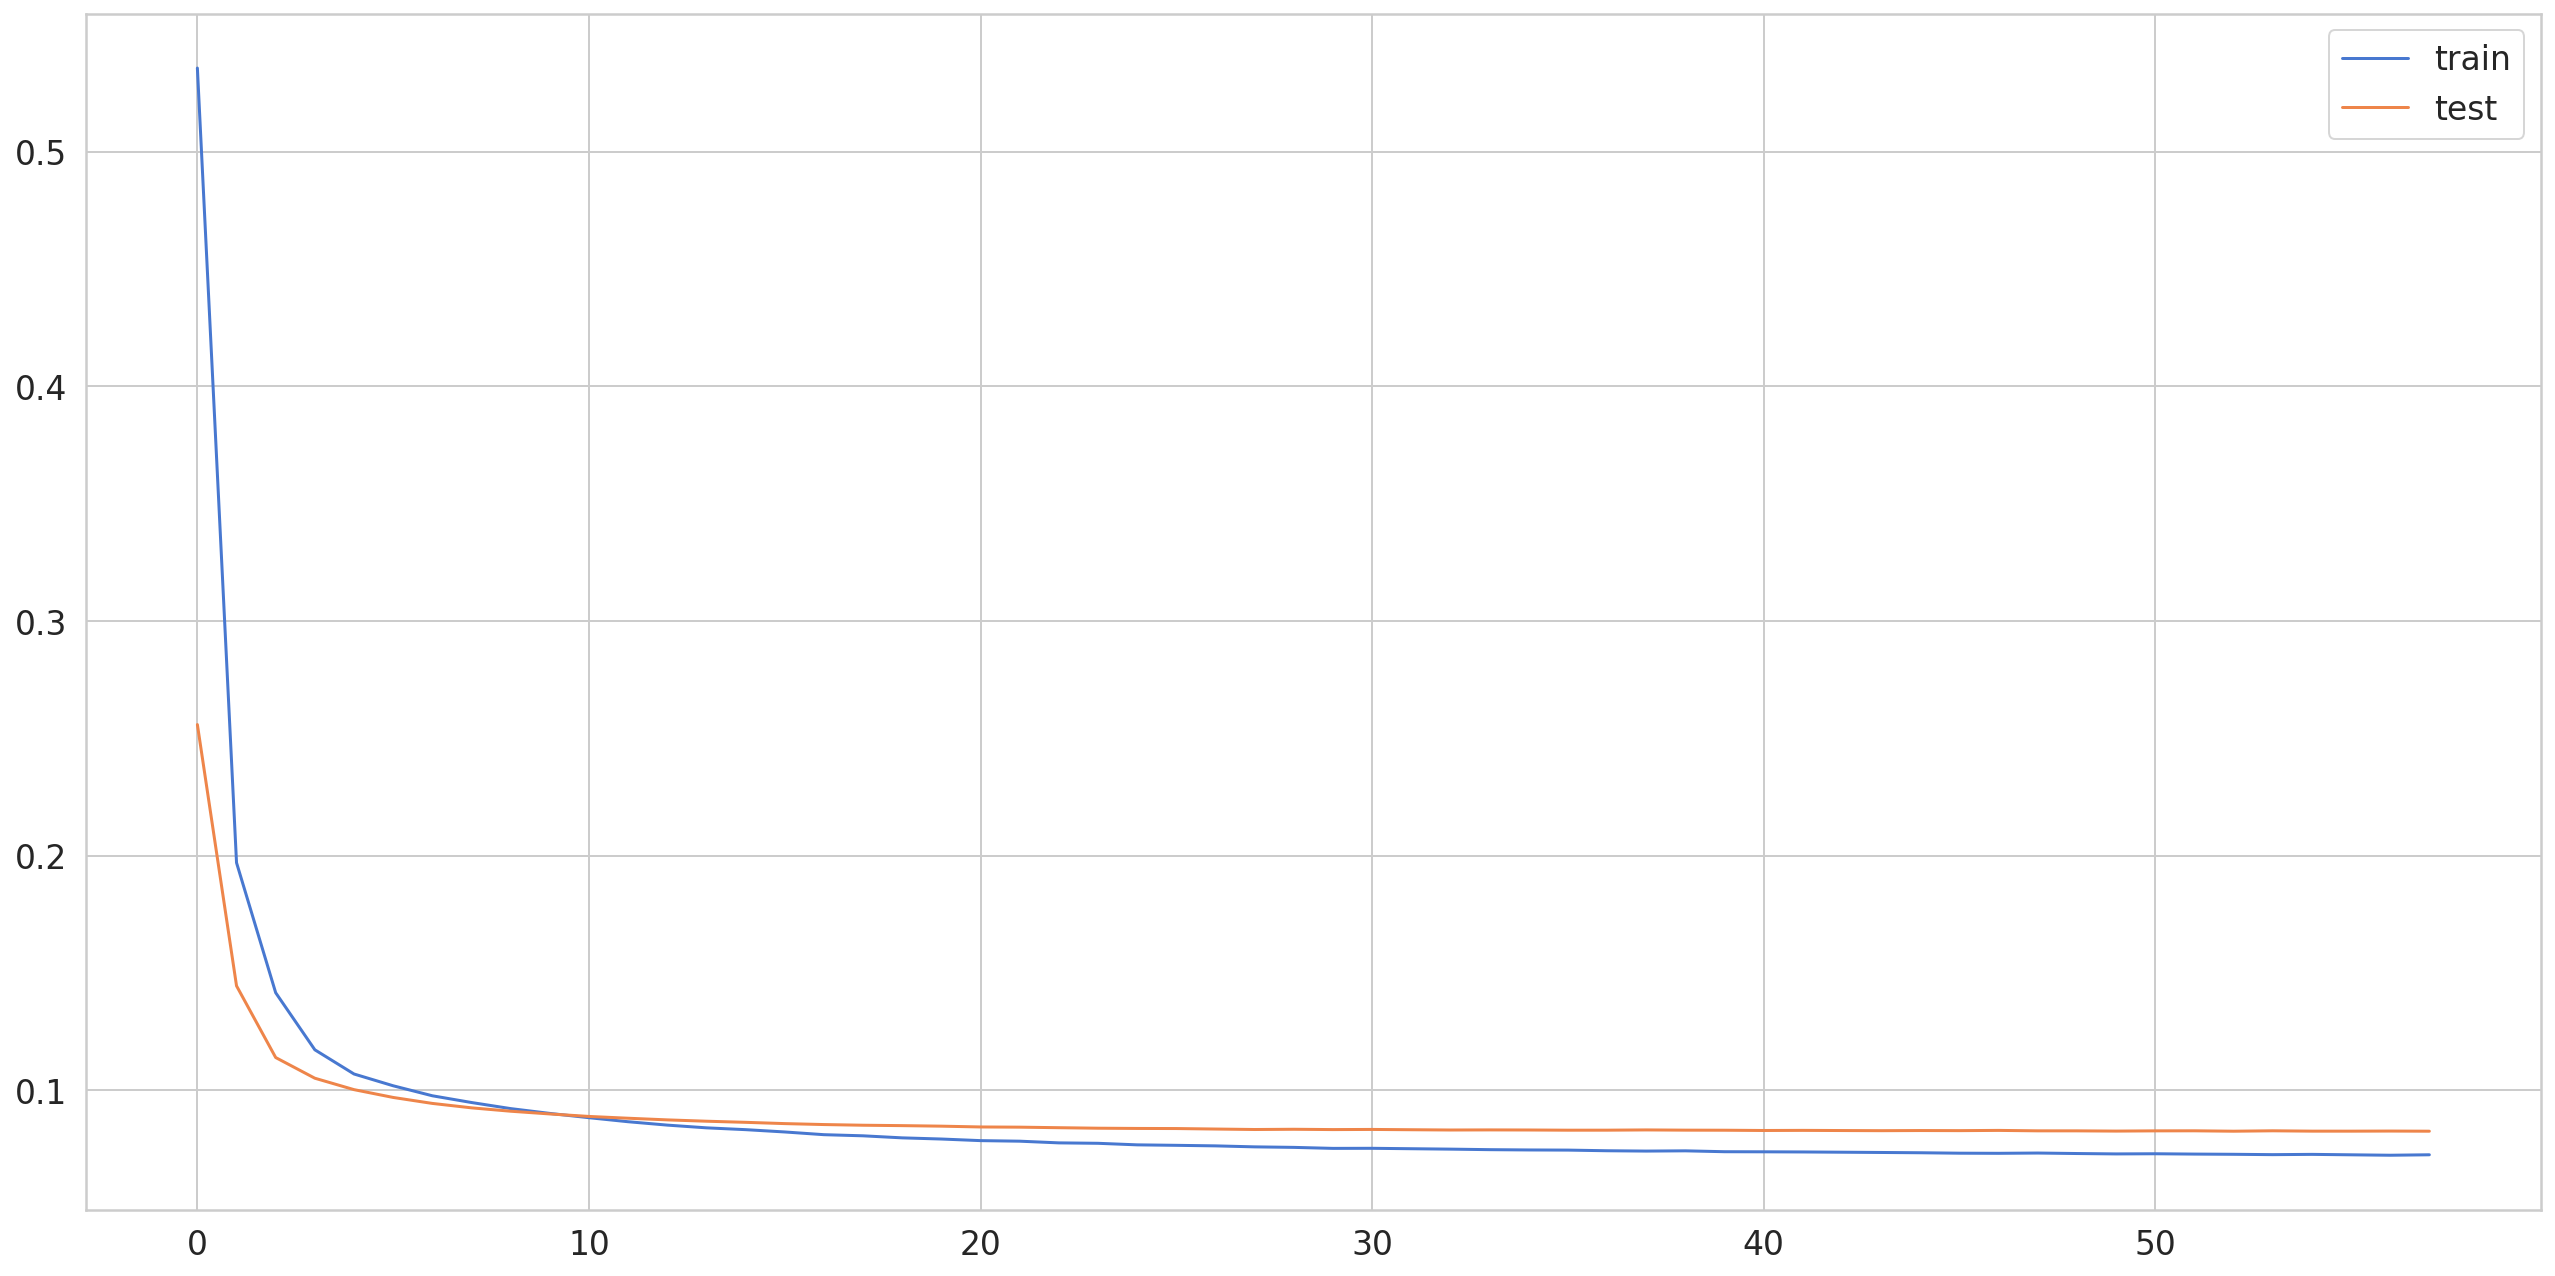

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

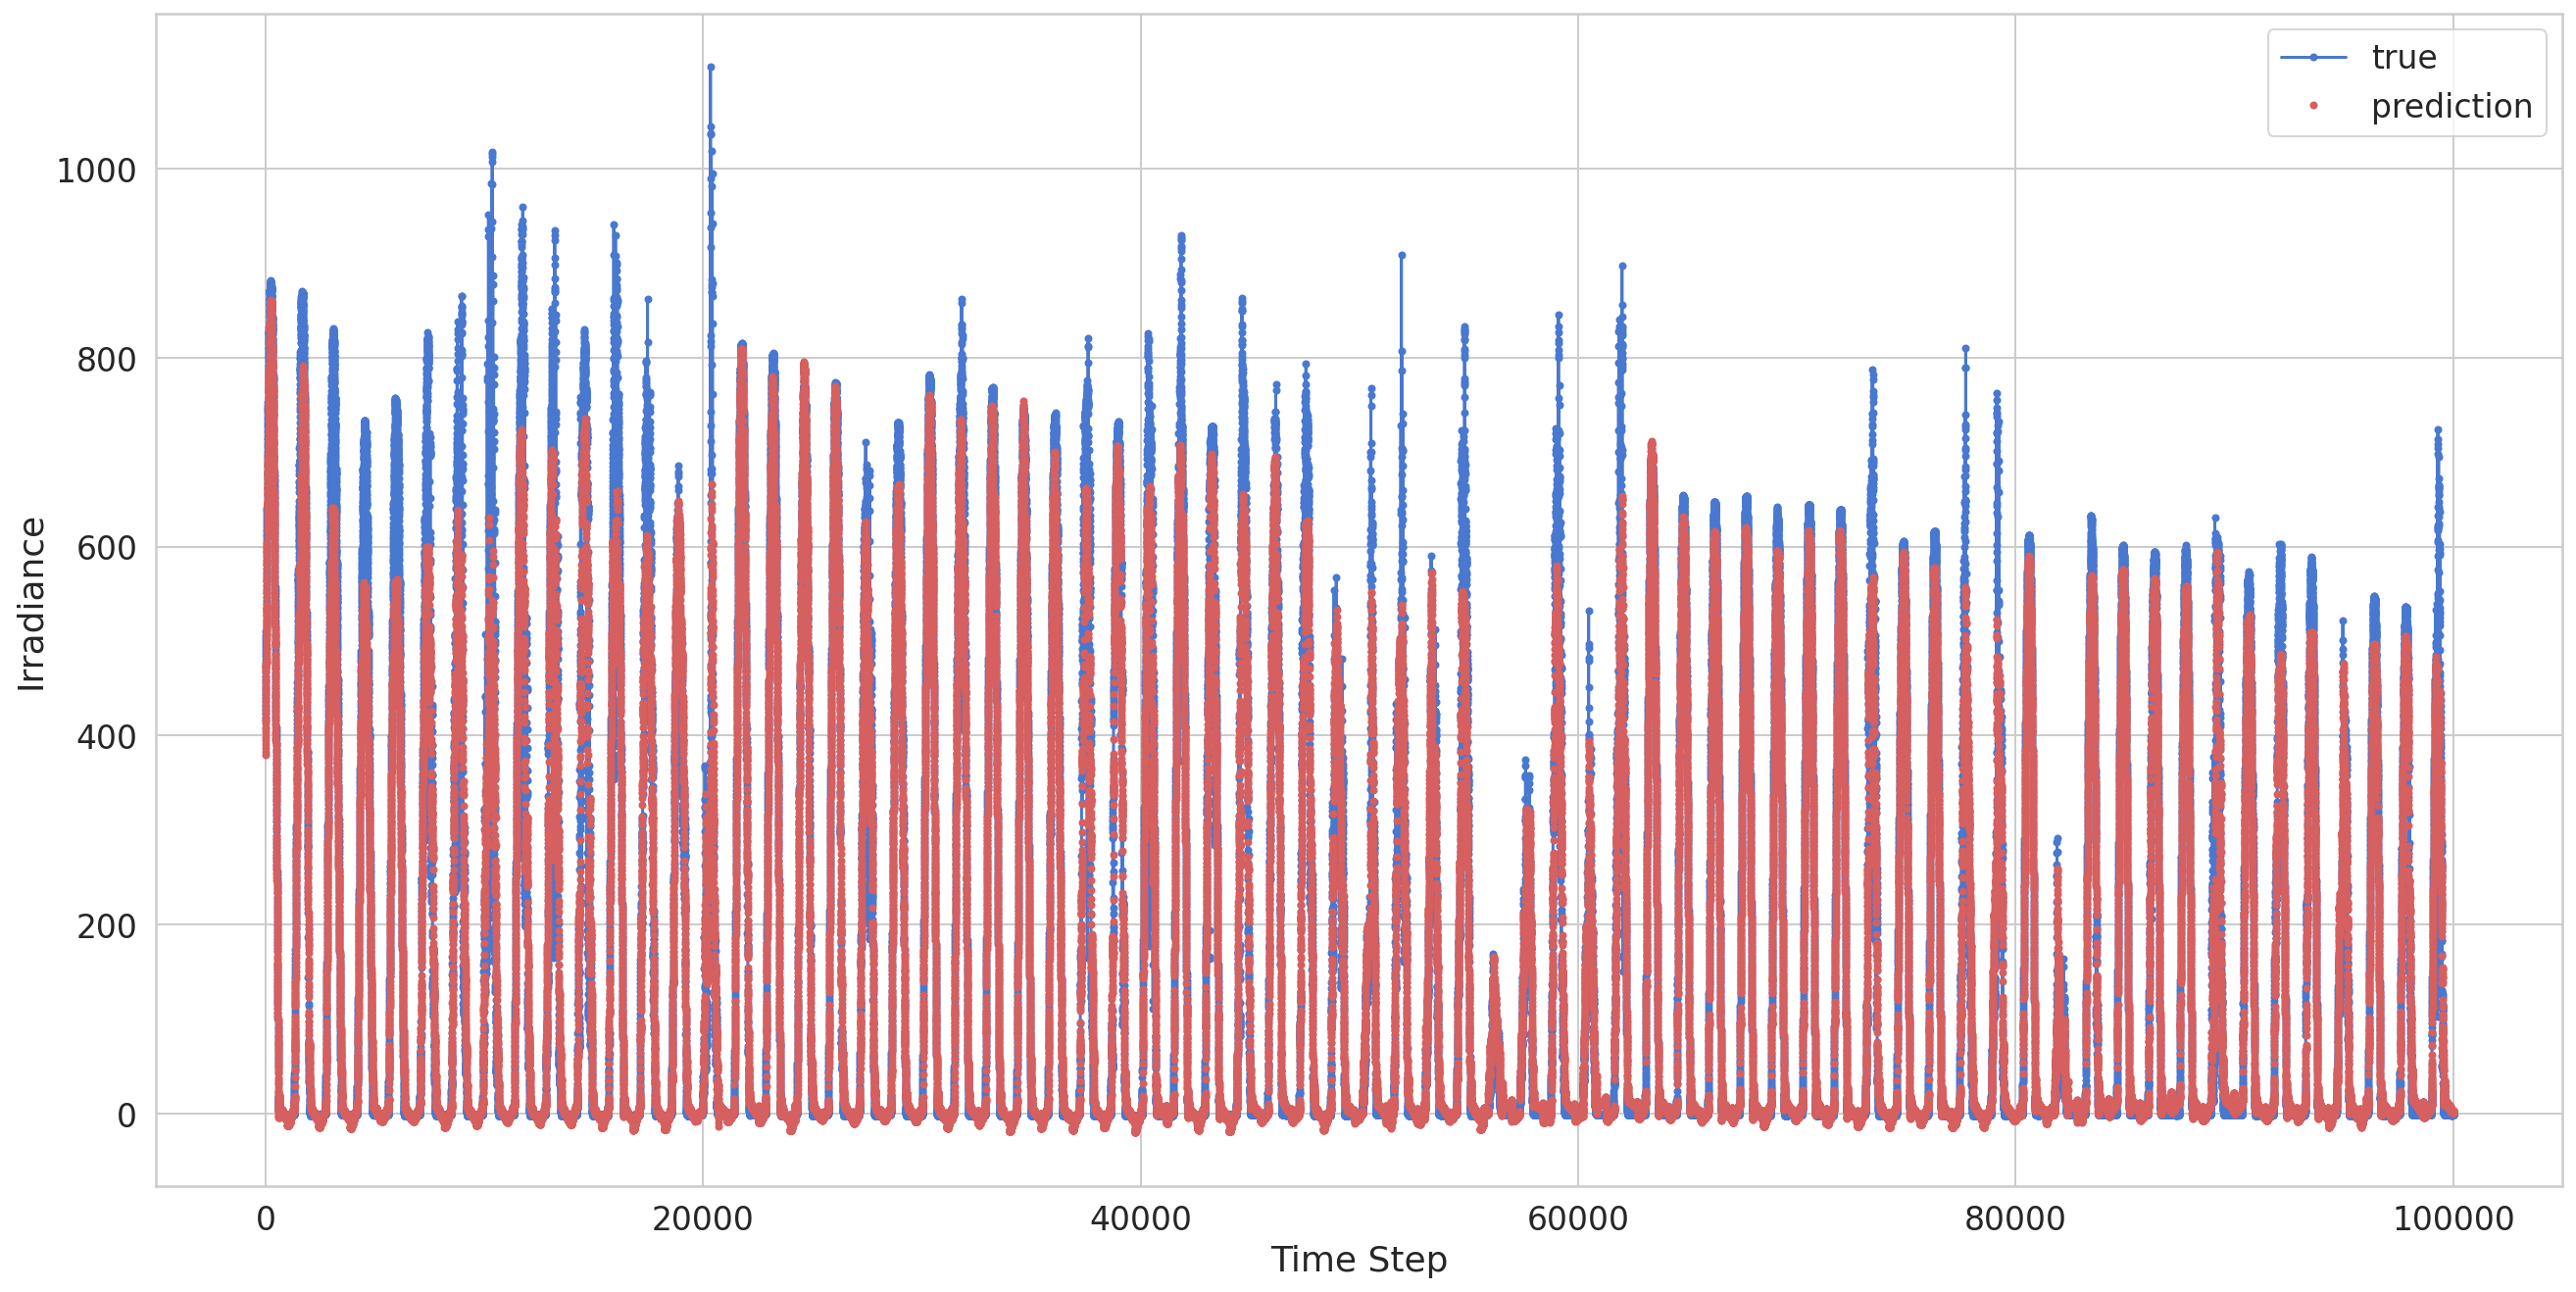

In [ ]:
plt.plot(y_test_inv.flatten()[:100000], marker='.', label="true")
plt.plot(y_pred_inv.flatten()[:100000], 'r.', label="prediction")
plt.ylabel('Irradiance')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
def create_dataset_test(X, time_steps):
    Xs = []
    for i in range(1):
      v = X.iloc[(len(X) - data_window - i):(len(X) - i)].values
      Xs.append(v)        
    return np.array(Xs)

In [ ]:
temp = 300

vals = np.zeros(temp)

for i in range(1,temp+1):
  df_test = pd.read_csv('/content/drive/MyDrive/Shell Hackathon Level 2 Test Data/{}/weather_data.csv'.format(i))
  df_test = df_test[df_test['Total Cloud Cover [%]'] >= 0]

#  df_test['time'] = 0
#  for j in range(len(df_test)):
#    df_test['time'][j] = i%1440

  df_test['hour'] = pd.to_datetime(df_test['MST'],format='%H:%M').dt.hour

  df_test.rename(columns = {'Direct sNIP [W/m^2]':'snip', 'Total Cloud Cover [%]': 'cloud cover', 
                     'Peak Wind Speed @ 6ft [m/s]': 'wind speed', 
                     'Avg Wind Direction @ 6ft [deg from N]': 'wind dir',
                     'Tower RH [%]': 'rh', 'Global CMP22 (vent/cor) [W/m^2]': 'irr',
                     'Tower Dry Bulb Temp [deg C]': 'temp', 'Moisture': 'moisture',
                     'Albedo (CMP11)': 'albedo'}, inplace = True)
  #req_cols = ['snip', 'temp', 'cloud cover', 'irr']

  df_test = df_test[req_cols]

  df_test.loc[:, f_columns] = f_transformer.transform(df_test[f_columns].to_numpy())
  df_test['irr'] = cnt_transformer.transform(df_test[['irr']])

  X_test = create_dataset_test(df_test, time_steps)
  
  y_pred = model.predict(X_test)

  #y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
  y_pred_inv = cnt_transformer.inverse_transform(y_pred)

  vals[i-1] = (y_pred_inv[0])/1.0
  if i%30==0:
    print(int(i/3), end=' ')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


10 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


20 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


30 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


40 50 60 70 80 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

90 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


100 

In [ ]:
#X_test[0]

In [ ]:
vals.shape

(300,)

In [ ]:
pd.DataFrame(vals).to_csv("/content/drive/MyDrive/Shell Hackathon Submission/data{}.csv".format(time_steps))

In [ ]:
time_steps

20